# Tariff Rates Optimization Problem

In [5]:
using JuMP
using HiGHS
using Plots
using StatsPlots
using Random, Distributions
Random.seed!(123) # Setting the seed
using Clustering
using StatsBase
using LinearAlgebra
using Distances
using Pluto
using ProgressBars

In [ ]:
for i in ProgressBar(1:5)
    sleep(0.5)
    print(i, "/5")
end

## Dataset Generation

### Energy demand throughout the day

We assume that the demand of energy follows a normal distribution $\mathcal{N}(\mu(t),\sigma^2)$ at any time $t$ in the day, with a mean $\mu(t)$ following a sinus function :
$$
\mu(t) = B + A\sin(\omega t + \varphi)
$$

In [30]:
# Energy demand (continuous)
DAY_HOURS = 24
σ = 2000
function mean_demand(t; min_power=15000, max_power=40000, peak_time=16)
    A = (max_power - min_power) / 2  # Amplitude
    B = (max_power + min_power) / 2  # Average
    ω = 2π / DAY_HOURS
    φ = π/2 - peak_time * ω
    return B + A * sin(ω*t + φ)
end

# Plot of the energy demand
δ = 0:0.1:24
d = mean_demand.(δ)
d⁺ = d .+ σ     
d⁻ = d .- σ
p1 = plot(δ, d, label="Mean Demand μ(t)", 
     xlabel="Time (hours)", 
     ylabel="Power (MW)",
     title="City Energy Consumption Over 24 Hours", 
     linewidth=2, 
     color=:blue,
     tickfontsize=8,
     guidefontsize=12,
     titlefontsize=16)
plot!(δ, d⁺, label="μ(t) + σ", linestyle=:dash, color=:green)
plot!(δ, d⁻, label="μ(t) - σ", linestyle=:dash, color=:red);


### Data Simulation
We assume that energy consumption informations of the city has been taken for a certain number of weeks. We generate in this part a dataset that corresponds to this amount of time.

In [7]:
# Time discretisation
WEEKS = 500
DAYS_PER_WEEK = 7
T = 12                       # Number of time periods
𝒯 = 1:T                      # Time periods index set
ΔT = DAY_HOURS / T           # Span of a period
tt = [(t-1)*ΔT for t in 𝒯]   # Beginning hours of periods
dataset_size =  WEEKS * DAYS_PER_WEEK

# Data sample from normal law
Π₀ = repeat([1/dataset_size], dataset_size)  # Probabilities of scenarios
D₀ = zeros(dataset_size, T)
for t in 𝒯
    distribution = Normal(mean_demand(tt[t]), σ)
    D₀[:,t] = rand(distribution, dataset_size)
end

# Create a boxplot for each time period
p2 = boxplot(𝒯, eachcol(D₀), 
        label="", 
        xlabel="Time Periods (indices)", 
        ylabel="Power Demand (MW)", 
        title="Power Demand Through Day Time\nSimulated Over $WEEKS weeks", 
        color=:blue,
        tickfontsize=8,
        guidefontsize=12,
        titlefontsize=16,
        xticks=𝒯);

### Visuals

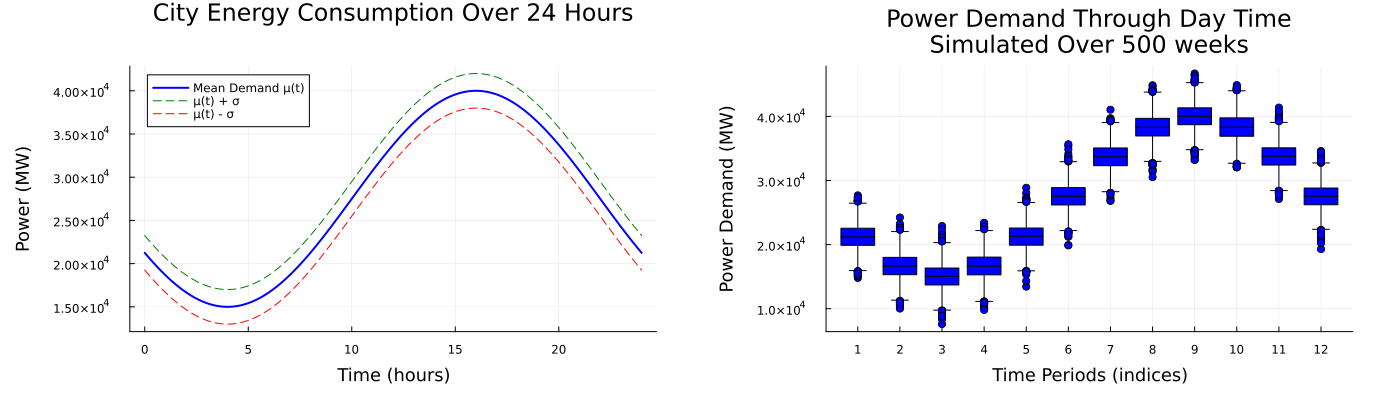

In [8]:
p = plot(p1, p2, layout=(1, 2), size=(1400, 400), margin=10Plots.mm)
savefig(p, "energy demand through the day.png")
p

### Generators Caracteristics
We assume having multiple types of generators having different performances.  
Values are from *H. Paul Williams - Model Building in Mathematical Programming-Wiley (2013)*.

In [9]:
N = [30, 15, 10]          # Number of generators of each type
m = [850, 1250, 1500]     # Min powers
M = [2000, 1750, 4000]    # Max powers
e = [1000, 2600, 3000]    # Costs per hour at minimum level
c = [2, 1.30, 3]          # Costs per hour above minimum
F = [2000, 1000, 500]     # Starting costsf
h = [ΔT for i=1:T]        # Hours in each period
C = h' .* c               # Costs per hour per megawatt above minimum level multiplied by the number of hours in the period
E = h' .* e               # Costs per hour for operating at minimum level multiplied by the number of hours in the period
ℐ = 1:length(N);          # Generator type index set

## Model Implementation

In this part are implemented two different ways to model the problem: with known demand in advance (deterministic) and with demand following scenarios having a certain probability (stochastic).

### Determinitic Model

In [19]:
function generate_deterministic_model(D)  # Demand D
    
    # Solver
    model = Model(HiGHS.Optimizer)
    set_silent(model)

    @variable(model, x[i in ℐ, t in 𝒯] >= 0)                                          # Total output rate from generators of type i in period t
    @variable(model, n[i in ℐ, t in 𝒯] >= 0, Int)                                     # Number of generating units of type i working in period t
    @variable(model, s[i in ℐ, t in 𝒯] >= 0, Int)                                     # Number of generators of type i started up in period t*
    @constraint(model, [i in ℐ, t in 𝒯], s[i,t] >= n[i,t] - n[i, t-1 > 0 ? t-1 : T])  # Startups constraints (periodic)
    @constraint(model, [i in ℐ, t in 𝒯], n[i,t] <= N[i])                              # Upper bound for active generators
    @constraint(model, [t in 𝒯], sum(x[i,t]    for i in ℐ) >= D[t])                   # Demand must be met
    @constraint(model, [t in 𝒯], sum(M[i]*n[i,t] for i in ℐ) >= 1.15*D[t])            # 15% reserve margin
    @constraint(model, [i in ℐ, t in 𝒯], x[i,t] >= m[i]*n[i,t])                       # Min output constraint
    @constraint(model, [i in ℐ, t in 𝒯], x[i,t] <= M[i]*n[i,t])                       # Max output constraint

    # Objective function
    @objective(model, Min, sum(E[i,t]*n[i,t] + F[i]*s[i,t] + C[i,t]*(x[i,t] - m[i]*n[i,t]) for i in ℐ, t in 𝒯))

    return model, n, s
end;

### Two Stage Stochastic Model (2SSP)

To model uncertainty, we chose 2SSP. That means that we ignore the demand before the beginning of the day, and we fully know it just after.

In [22]:
function generate_stochastic_model(D, Π)  # Demand D, probability of scenarios Π

    # Scenarios index set Ξ
    Ξ = 1 : size(D,1)
    
    # Solver
    model = Model(HiGHS.Optimizer)
    set_silent(model)

    # First stage
    @variable(model, n[i in ℐ, t in 𝒯] >= 0, Int)                                       # Number of generating units of type i working in period t
    @variable(model, s[i in ℐ, t in 𝒯] >= 0, Int)                                       # Number of generators of type i started up in period t*
    @constraint(model, [i in ℐ, t in 𝒯], s[i,t] >= n[i,t] - n[i, t-1 > 0 ? t-1 : T])    # Startups constraints (periodic)
    @constraint(model, [i in ℐ, t in 𝒯], n[i,t] <= N[i])                                # Upper bound for active generators
    @expression(model, first_cost, sum(E[i,t]*n[i,t] + F[i]*s[i,t] for i in ℐ, t in 𝒯)) # First stage cost

    # Second stage
    @variable(model, x[i in ℐ, t in 𝒯, ξ in Ξ] >= 0)                                                 # Total output rate from generators of type i in period t
    @constraint(model, [t in 𝒯, ξ in Ξ], sum(x[i,t,ξ]    for i in ℐ) >= D[ξ,t])                      # Demand must be met
    @constraint(model, [t in 𝒯, ξ in Ξ], sum(M[i]*n[i,t] for i in ℐ) >= 1.15*D[ξ,t])                 # 15% reserve margin
    @constraint(model, [i in ℐ, t in 𝒯, ξ in Ξ], x[i,t,ξ] >= m[i]*n[i,t])                            # Min output constraint
    @constraint(model, [i in ℐ, t in 𝒯, ξ in Ξ], x[i,t,ξ] <= M[i]*n[i,t])                            # Max output constraint
    @expression(model, second_cost[ξ in Ξ], sum(C[i,t]*(x[i,t,ξ] - m[i]*n[i,t]) for i in ℐ, t in 𝒯)) # Second stage cost

    # Objective function
    @objective(model, Min, first_cost + sum(Π[ξ]*second_cost[ξ] for ξ in Ξ))

    return model, n, s, first_cost, second_cost
end;

## Scenarios Reduction Methods

In this part we propose different ways to generate scenarios for the 2SSP model.

### K-means

In [12]:
function scen_gen_kmeans(D, k)
    result = kmeans(D', k)
    D_centroids = result.centers'  # Demand as centers of clusters
    Π = [sum(result.assignments .== a) for a in 1:k] ./ dataset_size  # Probability of scenarios
    return D_centroids, Π
end;

### Hierarchical Clustering
Hierarchical clustering is a clustering technique that builds a hierarchy of clusters in a dendrogram structure. Ward’s method is a popular linkage criterion for agglomerative clustering. It minimizes the total within-cluster variance at each step by merging the pair of clusters that results in the smallest increase in total variance. 

In [13]:
function scen_gen_hclust(D, k)
    dist_matrix = pairwise(Euclidean(), D') # Calculate the pairwise distance matrix
    hcl = hclust(dist_matrix, linkage=:ward) # Perform hierarchical clustering with Ward distance
    clusters = cutree(hcl, k=k)
    Π = [sum(clusters .== c) for c in 1:k] ./ dataset_size  # Probability of scenarios
    D_centroids = [mean(D[clusters .== c, :], dims=1) for c in 1:k]
    D_centroids = vcat(D_centroids...)  # Convert to a matrix
    return D_centroids, Π
end;

### Scenarios Reduction Examples

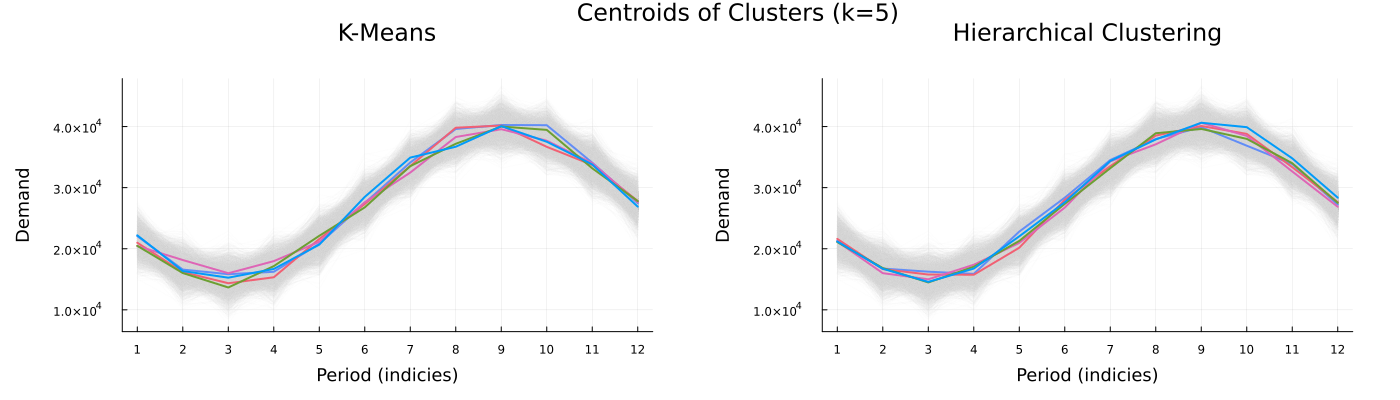

In [14]:
k = 5
D₁, Π₁ = scen_gen_kmeans(D₀, k)  # k-means clustering
D₂, Π₂ = scen_gen_hclust(D₀, k)  # Hierachical Clustering

α = 0.05
color = :lightgray

# Visualize centroids
p1 = plot(𝒯, D₀', alpha=α,
          legend=:topright,
          xlabel="Period (indicies)",
          ylabel="Demand",
          title="K-Means",
          label=false,
          xticks=𝒯,
          color=color,
          tickfontsize=8,
          guidefontsize=12,
          titlefontsize=16)

plot!(𝒯, D₁',
      label=false,
      linewidth=2)

p2 = plot(𝒯, D₀', alpha=α,
          legend=:topright,
          xlabel="Period (indicies)",
          ylabel="Demand",
          title="Hierarchical Clustering",
          label=false,
          xticks=𝒯,
          color=color,
          tickfontsize=8,
          guidefontsize=12,
          titlefontsize=16)

plot!(𝒯, D₂',
      label=false,
      linewidth=2)

p = plot(p1, p2, layout=(1, 2), size=(1400, 400), margin=10Plots.mm, suptitle="Centroids of Clusters (k=$k)")
savefig(p, "scenario reduction example.png")
p

## In-sample and Out-of-sample Stability Analysis

### In-sample Stability

In [15]:
function in_sample_stability(k, scenario_gen_method, iterations=10)
    solutions = []
    for i in 1 : iterations

        # Split dataset between train 
        sub_indices = sample(1:dataset_size, round(Int, 0.8 * dataset_size), replace=false)
        D_sub = D₀[sub_indices, :]

        # Reduce the number of scenarios from train set
        D_reduced, Π_reduced = scenario_gen_method(D_sub, k)

        # Test performance on same subset
        model, _, _, _, _ = generate_stochastic_model(D_reduced, Π_reduced)
        optimize!(model)
        sol = objective_value(model)
        push!(solutions, sol)
    end
    return std(solutions)
end;

### Out-sample Stability

In [16]:
function out_sample_stability(k, scenario_gen_method, iterations=10)

    solutions = []
    for i in 1 : iterations

        # Split dataset between train and test 
        train_indices = sample(1:dataset_size, round(Int, 0.8 * dataset_size), replace=false)
        test_indices = setdiff(1:dataset_size, train_indices)
        D_train = D₀[train_indices, :]
        D_test = D₀[test_indices, :]

        # Reduce the number of scenarios from the train set
        D_reduced, Π_reduced = scenario_gen_method(D_train, k)

        # Retrieve solution from this simplified model
        simplified_model, n, s, _, _ = generate_stochastic_model(D_reduced, Π_reduced)
        optimize!(simplified_model)
        sol_n = value.(n)
        sol_s = value.(s)

        # Evaluate solution on test set
        model, n, s, _, _ = generate_stochastic_model(D_test, Π₀[test_indices])
        @constraint(model, [i in ℐ, t in 𝒯], n[i,t] == sol_n[i,t])
        @constraint(model, [i in ℐ, t in 𝒯], s[i,t] == sol_s[i,t])
        optimize!(model)
        # Check termination status
        if termination_status(model) in [MOI.OPTIMAL, MOI.FEASIBLE_POINT]
            push!(solutions, objective_value(model))
        else
            println("No feasible solution found for the test set.")
            push!(solutions, NaN)  # Add a placeholder value, e.g., NaN
        end
    end
    return std(solutions)
end;

In [1]:
function stability_analysis(k_values, scenario_gen_method, iterations=10)
    in_sample_std = []
    out_sample_std = []

    for k in k_values
        in_std = in_sample_stability(k, scenario_gen_method, iterations)
        out_std = out_sample_stability(k, scenario_gen_method, iterations)
        
        push!(in_sample_std, in_std)
        push!(out_sample_std, out_std)
    end

    return in_sample_std, out_sample_std
end;

### Computations

In [ ]:
k_values = [5, 10, 20, 40, 80, 160, 320, 640, 1280]
in_sample_std_kmean, out_sample_std_kmean = stability_analysis(k_values, scen_gen_kmeans)
in_sample_std_hclust, out_sample_std_hclust = stability_analysis(k_values, scen_gen_hclust);

### Visuals

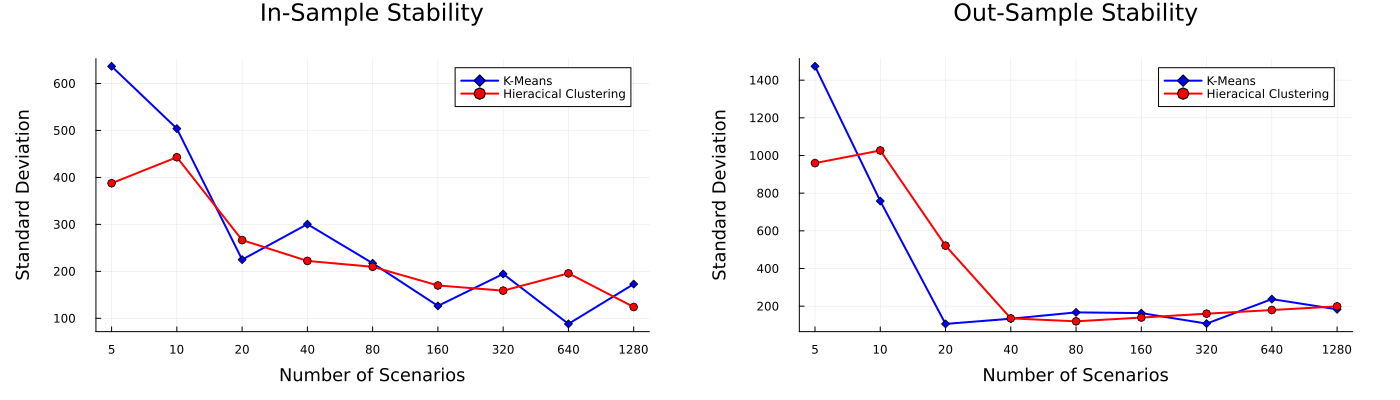

In [56]:
# Normalize k-values to a uniform scale
normalized_x = 1:length(k_values)  # Evenly spaced indices for plotting

# In-Sample Stability Plot
plot_in_sample = plot(normalized_x, in_sample_std_kmean, 
    lw=2, marker=:d, 
    label="K-Means", 
    xlabel="Number of Scenarios", 
    ylabel="Standard Deviation", 
    title="In-Sample Stability", 
    color=:blue,
    legend=:topright, 
    tickfontsize=8, 
    guidefontsize=12, 
    titlefontsize=16, 
    xticks=(normalized_x, string.(k_values)))  # Map normalized x to actual k-values

plot!(normalized_x, in_sample_std_hclust, 
    lw=2, marker=:o, 
    label="Hieracical Clustering", 
    color=:red)

# Out-Sample Stability Plot
plot_out_sample = plot(normalized_x, out_sample_std_kmean, 
    lw=2, marker=:d, 
    label="K-Means", 
    xlabel="Number of Scenarios", 
    ylabel="Standard Deviation", 
    title="Out-Sample Stability", 
    color=:blue,
    legend=:topright, 
    tickfontsize=8, 
    guidefontsize=12, 
    titlefontsize=16, 
    xticks=(normalized_x, string.(k_values)))  # Map normalized x to actual k-values

plot!(normalized_x, out_sample_std_hclust, 
    lw=2, marker=:o, 
    label="Hieracical Clustering", 
    color=:red)

# Combine the plots into a single layout
p = plot(plot_in_sample, plot_out_sample, layout=(1, 2), size=(1400, 400), margin=10Plots.mm)
savefig(p,"In & Out Sample Stability")
display(p)

With respect to the elbow rule, we can choose a set of $20$ scenarios using K-means or Hierarchical clustering with Ward's distance. Note that we can observe overfitting for greatest numbers of scenarios.

## Results

### Metrics functions

Given a dataset and probabilities of its instances, the following functions compute the stochastic, wait-and-see and expected value problem solutions.

#### Wait-And-See Problem Objective

In [57]:
function computeWS(D, Π)
    Ξ = 1 : size(D,1)
    aux_Π = [0 for _ in Π]
    modelWS, _, _, first_cost, second_cost = generate_stochastic_model(D, Π)
    WS = 0
    for ξ in Ξ
        aux_Π[ξ] = 1
        @objective(modelWS, Min, first_cost + sum(aux_Π[s] * second_cost[s] for s in Ξ))
        optimize!(modelWS)
        WS += Π[ξ] * objective_value(modelWS)
        aux_Π[ξ] = 0
    end
    return WS
end;

#### Expected Value Problem Objective

In [58]:
function computeEV(D, Π)

    # Retrieve first stage variables from deterministic solution
    D_avg = mean(D, dims=1)[:]
    model_mean, n, s = generate_deterministic_model(D_avg)
    optimize!(model_mean)
    sol_n_mean = value.(n)
    sol_s_mean = value.(s)

    # Form EV model by adding constraints to stochastic model
    modelEV, n, s, _, _ = generate_stochastic_model(D, Π)
    @constraint(modelEV, [i in ℐ, t in 𝒯], n[i,t] == sol_n_mean[i,t])
    @constraint(modelEV, [i in ℐ, t in 𝒯], s[i,t] == sol_s_mean[i,t])
    optimize!(modelEV)
    
    return objective_value(modelEV)
end;

#### Stochastic Problem Solution

In [59]:
function computeSP(D, Π)
    modelSP, n, s, _, _ = generate_stochastic_model(D, Π)
    optimize!(modelSP)
    return objective_value(modelSP), value.(n)
end;

#### All metrics

In [51]:
function compute_all_solutions(D, Π)
    WS = computeWS(D, Π)
    EV = computeEV(D, Π)
    SP, n_sol = computeSP(D, Π)
    return WS, EV, SP, n_sol
end;

### Reduced Stochastic Model Performances
As shown in the previous part we reduce the dataset to $20$ scenarios.

In [52]:
k = 20

D_kmeans, Π_kmeans = scen_gen_kmeans(D₀, k)
D_hclust, Π_hclust = scen_gen_hclust(D₀, k)

WS_kmeans, EV_kmeans, SP_kmeans, n_kmeans = compute_all_solutions(D_kmeans, Π_kmeans)
WS_hclust, EV_hclust, SP_hclust, n_hclust = compute_all_solutions(D_hclust, Π_hclust);


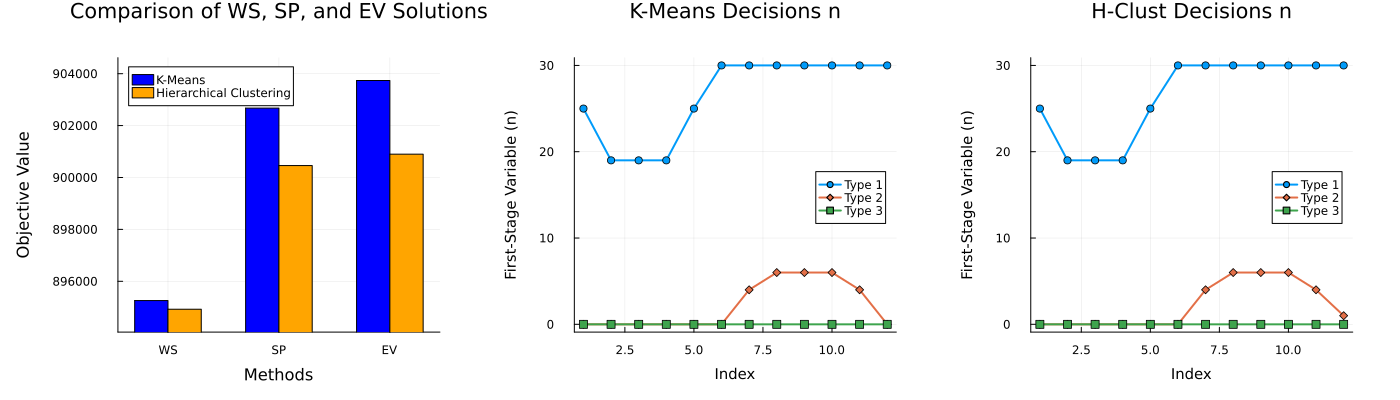

In [53]:
# Solution comparison data
methods = ["WS", "SP", "EV"]
kmeans_values = [WS_kmeans, SP_kmeans, EV_kmeans]
hclust_values = [WS_hclust, SP_hclust, EV_hclust]

# Calculate y-axis limits
min_val = min(minimum(kmeans_values), minimum(hclust_values))
max_val = max(maximum(kmeans_values), maximum(hclust_values))
y_min = min_val - 0.1 * (max_val - min_val)
y_max = max_val + 0.1 * (max_val - min_val)

# Grouping parameters
x = 1:length(methods)                 # Base x positions
bar_width = 0.3                       # Width of each bar
offset = bar_width / 2                # Offset between groups

# Bar plot comparison
p1 = plot(title = "Comparison of WS, SP, and EV Solutions", ylims = (y_min, y_max))
bar!(
    x .- offset, 
    kmeans_values, 
    bar_width = bar_width,
    label = "K-Means", 
    color = :blue, 
    xlabel = "Methods", 
    ylabel = "Objective Value",
    xticks = (x, methods), 
    legend = :topleft)
bar!(
    x .+ offset, 
    hclust_values, 
    bar_width = bar_width,
    label = "Hierarchical Clustering", 
    color = :orange)


labels = ["Type 1" "Type 2" "Type 3"]
markers = [:circle :diamond :square]

p2_kmeans = plot(𝒯, n_kmeans', label=labels, markers = markers, lw=2, legend=:right,
          xlabel="Index", ylabel="First-Stage Variable (n)", 
          title="K-Means Decisions n", titlefontsize=14, 
          guidefontsize=10, tickfontsize=8)

p2_hclust = plot(𝒯, n_hclust', label=labels, markers = markers, lw=2, legend=:right,
          xlabel="Index", ylabel="First-Stage Variable (n)", 
          title="H-Clust Decisions n", titlefontsize=14, 
          guidefontsize=10, tickfontsize=8)

# Combine plots
p = plot(p1, p2_kmeans, p2_hclust, layout=(1, 3), size=(1400, 400), margin=10Plots.mm)
savefig(p, "final_plot")
p